In [1]:
import numpy as np
import random
from datetime import datetime
import time
from collections import defaultdict
from helper_func import *
import pickle
import multiprocessing
import keras
from multiprocessing import Pool
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from collections import deque
from keras.activations import relu, linear
from keras.losses import mean_squared_error
from keras.optimizers import Adam
import tensorflow as tf

%load_ext autoreload

Using TensorFlow backend.
/Users/jgaustad/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jgaustad/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jgaustad/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jgaustad/anaconda3/lib/python3.7/site-pa

In [2]:
class pentago:
    """
    The class contains the boardgame and allows agents to execute moves. It saves all gameplay and boardstates in the history attrib.
    """

    def __init__(self, state = None):
        """Initializes the class reservation"""
        #print('initializing')
        
        if state == None:
            self.state = state = np.zeros((6,6), dtype=np.int)
        self.history = []
        self.winner = None
        self.gameover = False
        self.player_turn = 1
    
    def current_board_state(self):
        # need to return a copy or bad stuff happens
        return copy.copy(self.state)
    
    def game_history(self, player, move, cuad, rotatation):
        self.history.append((boardstate_to_ideal_key(self.state), ideal_state(self.state), player, move, cuad, rotatation))
        #return self.history

    def find_winner(self, board_state):
        player1_win = False
        player_min1_win = False
        diagonal1 = board_state.diagonal()
        diagonal2 = np.fliplr(board_state).diagonal()
        winning_slices =  np.vstack([board_state[1:,:].T, board_state[:-1,:].T, # all columns
                              board_state[:,1:], board_state[:,:-1], # all rows
                              diagonal1[1:], diagonal1[:-1], # diagonal 1
                              diagonal2[1:],diagonal2[1:], # diagonal 2
                              board_state.diagonal(offset=1), board_state.diagonal(offset=-1), # diagonal offsets 
                              np.fliplr(board_state).diagonal(offset=1), np.fliplr(board_state).diagonal(offset=-1)] ) # diagonal offsets
        sums = np.dot(winning_slices, np.array([1,1,1,1,1]))
        if 5 in sums: player1_win = True
        if -5 in sums: player_min1_win = True
        if player1_win == True or player_min1_win == True:
           # print("Player 1 winner?", player1_win, "Player -1 winner?", player_min1_win)
            self.gameover = True
            if player1_win == True:
                self.winner = 1
            elif player_min1_win ==True:
                self.winner = -1
            self.history.append(self.winner)
        return "Win"

    def check_gameover(self):
        if not 0 in self.state:
              self.gameover = True
              #print("The game board is full!")
        
    def full_move(self, move, cuad, direction, player, dtype=np.int):
        if player != self.player_turn:
            print( "error, wrong player turn. No move taken.")
            return 'Error, wrong player turn.'
        self.state = fullmove(self.state,move, cuad, direction, player)


        self.game_history(move, player, cuad, direction)
        self.find_winner(self.state) #return in find_winner if a winner is found
        self.check_gameover() #return in check_gameover
        if player == 1:
            self.player_turn = -1
        else:
            self.player_turn = 1
        #print('Successful Move')
        return self.state



In [3]:
class cnn_model:

    def __init__(self,list_density=None,lr=0.02):
        self.model = self.build_model(list_density,lr)

    def build_model(self,den,lr):
        model = Sequential()
        #model.add(tf.keras.Input(shape=(6,6,2,)))
        #for layer in den:
        model.add(Conv2D(
                            filters = 64, 
                            kernel_size = (3,3),
                            strides = (3,3),
                            padding = 'valid',
                            activation = relu,
                            input_shape = (6,6,2)))
        model.add(Flatten())
        model.add(Dense(256, activation = relu))
        model.add(Dense(128, activation = relu))


        model.add(Dense(1, activation=linear))
        
        model.compile(loss=mean_squared_error,optimizer=Adam(lr=lr))
        print(model.summary())
        return model



    def update_model(self,states_batch, q_batch, epochs = 1):

        self.model.fit(states_batch,q_batch,epochs = epochs, verbose=1)

    def predict_model(self, state_batch):
        return self.model.predict_on_batch(state_batch)
        

In [4]:
class nn_agent:
    
    def __init__(self, nn, player = 1, epsilon = 1, epsilon_decay = .99995, epsilon_min = .5):
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.nn = nn
        self.player = player
        self.epsilon_min = epsilon_min
        
            
    def get_avail_moves(self,boardstate):
        """
        This method creates a list with available spaces in the board and combination of quadrant and rotation
        The input is the board state (6x6) numpy array
        """
        x = np.where(boardstate == 0)
        #print(x)
        available_positions_for_placement = list(zip(x[0], x[1]))
        
        # all available positions (p), quadrants(q), rotations(r)
        available_moves = [(p,q,r) for p in available_positions_for_placement for q in [1,2,3,4] for r in [-1,1]]
        #print(len(available_moves))
        return available_moves
    
    def get_possible_next_boardstates(self, boardstate):
        next_possible_boardstates = defaultdict(list)
        for move in self.get_avail_moves(boardstate):
            possible_boardstate = fullmove(boardstate,*move, self.player)
            #print(possible_boardstate)
            key = boardstate_to_ideal_key(possible_boardstate)
            cnn_input = boardstate_to_cnn_input(possible_boardstate)
            next_possible_boardstates[key].append((cnn_input, move))
            
        return next_possible_boardstates
    
    def make_move(self, game):
        
        # get the current boardstate from the pentago class
        boardstate = game.current_board_state()
        
        # get possible next possible boardstates
        t0 = time.time()
        next_possible_boardstates = self.get_possible_next_boardstates(boardstate)
        key_list = list(next_possible_boardstates.keys())

        # determine if to take random move
        if np.random.rand() < self.epsilon:
            random_bs = random.choice(key_list)
            random_mv = next_possible_boardstates[random_bs][0][1] # capture the move needed
            
            game.full_move(*random_mv,self.player)
            
        else:
            #print("not random", self.player)
           # t0 = time.time()
            nn_input_boardstate = []
            move = []
            for k,v in next_possible_boardstates.items():
                nn_input_boardstate.append(v[0][0])
                #print(v[0][0].shape)
                move.append(v[0][1])

            nn_input_batch = np.array(nn_input_boardstate)

            q_values = self.nn.predict_model(nn_input_batch)
            q_values *= self.player

            max_q = np.argmax(q_values)

            mv_to_take = move[max_q]
            game.full_move(*mv_to_take, self.player)
        

In [7]:
def reward_func(history, decay_factor = .9):
    winner = history[-1]
    nn_inputs = []
    rewards = []
    for boardposition in history[-2::-1]:
        nn_inputs.append(boardposition[1])
        rewards.append(winner)
        winner *= decay_factor
    return nn_inputs, rewards


In [10]:
def little_sim(agents):
    '''This function simulates a game and allows for multiprocessing calls.'''
    agent1, agent2 = agents
    g = pentago()
    while g.gameover == False:
        agent1.make_move(g)
        if g.gameover ==True: break
        agent2.make_move(g)
    #print('gameover.')
    return g


In [40]:
def big_sim_parallel_nn(agent1, agent2, n_steps = 1, games_per_step = 32, nn_to_update = [], parallel_threads = 6):
    game_times = []
    evals = []
    eval_times = []
    epsilons = []
    nn_update_times = []
    winner_list = []
    running_boardstates = []
    running_rewards = []
    
    for n in range(n_steps):
        print('game_step', n, end = ' ')
        game_start = time.time()
        
        #if __name__ == '__main__':
        #    with Pool(parallel_threads) as p:
        #        game_returns = p.map(little_sim, [(agent1,agent2)]*games_per_step)
        game_returns = [little_sim((agent1,agent2)) for x in range(games_per_step)] #comment out parallelilization if needed.
        
            
        game_times.append(time.time()-game_start)
            
        player1_winner = 0
        player2_winner = 0
        # check for winner and create update batch
        nn_input_batch = []
        rewards_for_batch = []
        for game in game_returns:
            if game.winner:
                if game.winner == 1: player1_winner += 1
                else: player2_winner += 1
                
                # accumulate rewards and inputs for training
                boardstates, rewards = reward_func(game.history)
                nn_input_batch += [boardstate_to_cnn_input(bs) for bs in boardstates] # add nn_inputs to training list (x)
                rewards_for_batch += rewards # add rewards to training list (Y)
        winner_list.append(player1_winner)
        
        # evaluate the model
        t0 = time.time()
        for nn in nn_to_update:
            evals.append(nn.model.evaluate(np.array(nn_input_batch), np.array(rewards_for_batch)))
        eval_times.append(time.time() - t0)

        
        # train the neural network
        t0 = time.time()
        print(f"updating with {len(nn_input_batch)}, {len(rewards_for_batch)} training batch.")
        running_boardstates += nn_input_batch
        running_rewards += rewards_for_batch
        for nn in nn_to_update:
            nn.update_model(np.array(running_boardstates[-5000:]), np.array(running_rewards[-5000:]))
        nn_update_times.append(time.time() - t0)


        print("player 1 wins:", player1_winner)
        print("player 2 wins:", player2_winner)
        #print("simulations took", game_times[-1], "seconds.")
        print("neural network update time:", nn_update_times[-1], "seconds.")
        try:
            print("eval score on batch:", evals[-1])
        except:
            pass
        print("epsilons agent1 and agent2:", agent1.epsilon, agent2.epsilon)
        epsilons.append((agent1.epsilon, agent2.epsilon))
        if agent1.epsilon > agent1.epsilon_min: agent1.epsilon *= agent1.epsilon_decay
        else: agent1.epsilon == agent1.epsilon_min
        if agent2.epsilon > agent2.epsilon_min: agent2.epsilon *= agent2.epsilon_decay
        else: agent2.epsilon == agent2.epsilon_min

    # end of simulation runs, save q_table(s) to disk
    nn_num = 1
    time_str = str(datetime.now())[:19].replace(':','_')
    for nn in nn_to_update:
        with open(f'CNN_{nn_num}_'+time_str+'.pickle', 'wb') as file:
            pickle.dump(nn, file, protocol = pickle.HIGHEST_PROTOCOL)
        nn_num += 1
    
    return epsilons, nn_update_times, winner_list, evals, eval_times
            

In [34]:
#NOTE: You will overwrite a trained model if run this after training.
nn_1 = cnn_model()
nn_2 = cnn_model()
agent1 = nn_agent(player = 1,  nn = nn_1, epsilon_min = 0, epsilon_decay = .99, epsilon = .3)
agent2 = nn_agent(player = -1,  nn = nn_2, epsilon_min = 0, epsilon_decay = .99, epsilon = 1)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 2, 2, 64)          1216      
_________________________________________________________________
flatten_19 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_56 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 129       
Total params: 100,033
Trainable params: 100,033
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_20"
_________________________________________________________________
Layer (type)       

In [35]:
returns = big_sim_parallel_nn(agent1, agent2, n_steps=25, games_per_step=32, nn_to_update=[nn_1], parallel_threads=6)

893/893 [==============================] - 0s 436us/step
updating with 893, 893 training batch.
Epoch 1/1
893/893 [==============================] - 2s 2ms/step - loss: 0.2610
player 1 wins: 16
player 2 wins: 15
neural network update time: 2.013617992401123 seconds.
eval score on batch: 0.19536430767475557
epsilons agent1 and agent2: 0.3 1
823/823 [==============================] - 0s 53us/step
updating with 823, 823 training batch.
Epoch 1/1
1716/1716 [==============================] - 0s 186us/step - loss: 0.1850
player 1 wins: 15
player 2 wins: 14
neural network update time: 0.32364511489868164 seconds.
eval score on batch: 0.190859961317782
epsilons agent1 and agent2: 0.297 0.99
830/830 [==============================] - 0s 52us/step
updating with 830, 830 training batch.
Epoch 1/1
2546/2546 [==============================] - 0s 189us/step - loss: 0.1840
player 1 wins: 15
player 2 wins: 15
neural network update time: 0.48554301261901855 seconds.
eval score on batch: 0.1882652458297

In [36]:
returns2 = big_sim_parallel_nn(agent1, agent2, n_steps=25, games_per_step=32, nn_to_update=[nn_1], parallel_threads=6)

765/765 [==============================] - 0s 52us/step
updating with 765, 765 training batch.
Epoch 1/1
765/765 [==============================] - 0s 212us/step - loss: 0.1616
player 1 wins: 25
player 2 wins: 6
neural network update time: 0.16590213775634766 seconds.
eval score on batch: 0.1615768463003869
epsilons agent1 and agent2: 0.233346407819744 0.7778213593991465
813/813 [==============================] - 0s 63us/step
updating with 813, 813 training batch.
Epoch 1/1
1578/1578 [==============================] - 0s 215us/step - loss: 0.1642
player 1 wins: 25
player 2 wins: 7
neural network update time: 0.3450188636779785 seconds.
eval score on batch: 0.16841471841533612
epsilons agent1 and agent2: 0.23101294374154654 0.7700431458051551
804/804 [==============================] - 0s 62us/step
updating with 804, 804 training batch.
Epoch 1/1
2382/2382 [==============================] - 0s 207us/step - loss: 0.1603
player 1 wins: 25
player 2 wins: 6
neural network update time: 0.5008

In [42]:
random_agent = nn_agent(player = -1,  nn = nn_1, epsilon_min = 0, epsilon = 1, epsilon_decay = 1)  # no decay, fully random
agent1.epsilon = 0 # set agent1 to no random moves
returns3 = big_sim_parallel_nn(agent1, random_agent, n_steps=1, games_per_step=32, nn_to_update=[], parallel_threads=6) # no update

game_step 0 updating with 690, 690 training batch.
player 1 wins: 29
player 2 wins: 3
neural network update time: 0.00025177001953125 seconds.
epsilons agent1 and agent2: 0 1


In [29]:
p1_winning_pc = [x/32 for x in winner_list]
steps = list(range(50))

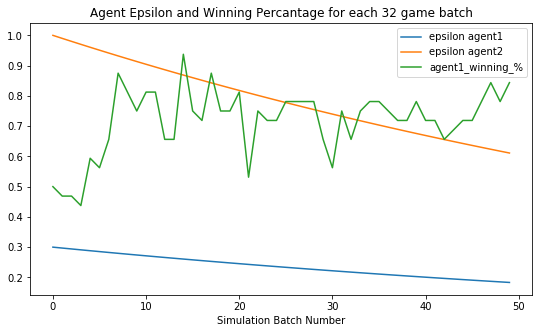

In [27]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize = (9,5))
ax.plot(steps, eps1, label = "epsilon agent1")
ax.plot(steps, eps2, label = "epsilon agent2")
ax.plot(steps, p1_winning_pc, label = 'agent1_winning_%')
ax.set_title('Agent Epsilon and Winning Percantage for each 32 game batch')
ax.set_xlabel('Simulation Batch Number')
ax.legend()